In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# jt -t monokai -N -T -kl -nfs 10 -tfs 10 -cellw 80%
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

In [2]:
#export
from exp.nb_06 import *

## ConvNet

Let's get the data and training interface from where we left in the last notebook.

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
mnist_view = view_transform(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [6]:
nfs = [8,16,32,64,64]

In [7]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [8]:
%time run.fit(2, learn)

train: [1.081944140625, tensor(0.6495, device='cuda:0')]
valid: [0.2181462646484375, tensor(0.9337, device='cuda:0')]
train: [0.15559052734375, tensor(0.9514, device='cuda:0')]
valid: [0.11818975830078125, tensor(0.9651, device='cuda:0')]
CPU times: user 10.2 s, sys: 2.66 s, total: 12.9 s
Wall time: 20.1 s


## Batchnorm

### Custom

Let's start by building our own [`BatchNorm`](https://arxiv.org/pdf/1502.03167.pdf) layer from scratch.

In [36]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        # in the original paper they use mu = mu + alpha(mu_new-mu) -> mu = (1-alpha) mu + alpha mu_new
        # so they call momentum alpha while you'd expect it to be (1-alpha)! regardless..
        self.mom = mom
        self.register_buffer('eps',  torch.tensor([eps])) # note, I correctly registered eps as well because we need it at inference time
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1)) 
        self.register_buffer('vars',  torch.ones(1,nf,1,1)) # here we register buffer - this makes so the objects persist when we save the model
        self.register_buffer('means', torch.zeros(1,nf,1,1)) # cause mean and var are needed at inference time!
        # also allows for self.means and self.vars to be moved to the GPU when you ask for it!
        
    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True) # HERE IS BATCHNORM[2D]! (see fig below) AVERAGE OVER THE BATCH SIZE, height and width of an image!
        v = x.var ((0,2,3), keepdim=True) # the number of filters/channels stays the same, so we're normalizing each 'feature'
                                          # of the model via all the other features computed in the same layer over THIS batch!
        self.means.lerp_(m, self.mom)     # lerp is linear interpolation (in place because of the underscore)
        self.vars.lerp_ (v, self.mom)     # so, as you'd expect, this averages the current mean with m and mom -- same for vars
        return m,v
        
    def forward(self, x):
        if self.training:
            # with torch.no_grad(): 
            m,v = self.update_stats(x) # gradients are not propagated through m and v? in the original paper they are!
            # If we comment the above torch.no_grad() we can actually see that we reproduce the pytorch batchnorm results so I guess this is a whoopsie
        else: m,v = self.means,self.vars # at test time instead just recover the means and vars
        x = (x-m) / (v+self.eps).sqrt() # normalize x
        return x*self.mults + self.adds # rescale again with the learned parameters

In [37]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [38]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [39]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.231046015625, tensor(0.9276, device='cuda:0')]
valid: [0.0871938720703125, tensor(0.9734, device='cuda:0')]
train: [0.0664373095703125, tensor(0.9793, device='cuda:0')]
valid: [0.0954380615234375, tensor(0.9716, device='cuda:0')]
train: [0.0443581640625, tensor(0.9865, device='cuda:0')]
valid: [0.08458389892578125, tensor(0.9738, device='cuda:0')]


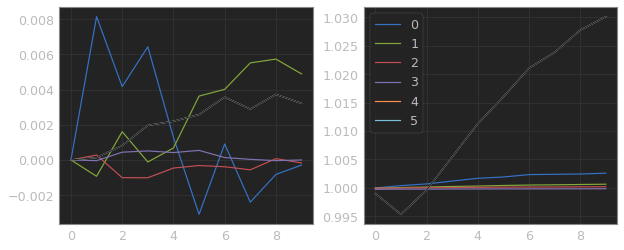

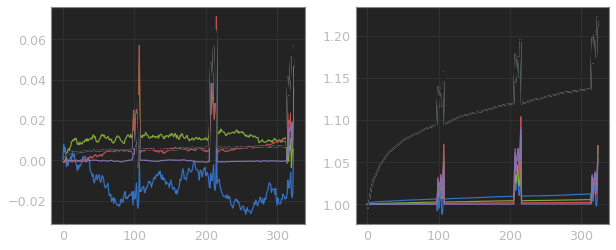

In [40]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(3, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [41]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs) #maybe push lr to 1. ?

In [31]:
%time run.fit(3, learn)

train: [0.2767694140625, tensor(0.9132, device='cuda:0')]
valid: [0.1388983154296875, tensor(0.9584, device='cuda:0')]
train: [0.090429638671875, tensor(0.9722, device='cuda:0')]
valid: [0.114901953125, tensor(0.9634, device='cuda:0')]
train: [0.064572587890625, tensor(0.9802, device='cuda:0')]
valid: [0.08802603149414062, tensor(0.9720, device='cuda:0')]
CPU times: user 7.84 s, sys: 1.7 s, total: 9.54 s
Wall time: 9.49 s


### Builtin batchnorm

In [42]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1)) # we can now use the pytorch layer
    return nn.Sequential(*layers)

In [43]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

train: [0.2285094140625, tensor(0.9279, device='cuda:0')]
valid: [0.113019140625, tensor(0.9657, device='cuda:0')]
train: [0.069314677734375, tensor(0.9783, device='cuda:0')]
valid: [0.07544990234375, tensor(0.9742, device='cuda:0')]
train: [0.0473320263671875, tensor(0.9849, device='cuda:0')]
valid: [0.06716075439453124, tensor(0.9808, device='cuda:0')]


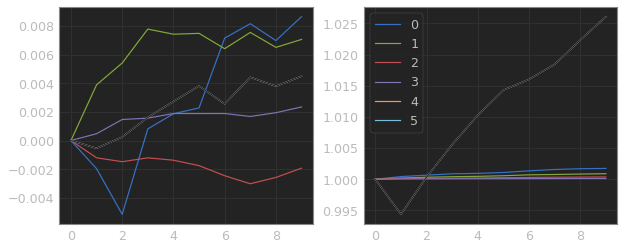

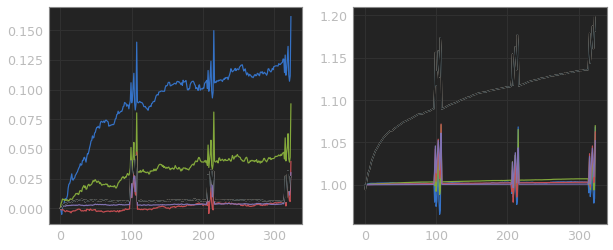

In [44]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(3, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

### With scheduler

Now let's add the usual warm-up/annealing.

In [45]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [53]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

train: [0.24465376953125, tensor(0.9270, device='cuda:0')]
valid: [0.10162515869140624, tensor(0.9696, device='cuda:0')]
train: [0.072149345703125, tensor(0.9772, device='cuda:0')]
valid: [0.1040728759765625, tensor(0.9698, device='cuda:0')]
train: [0.0502592236328125, tensor(0.9840, device='cuda:0')]
valid: [0.08563567504882813, tensor(0.9741, device='cuda:0')]
train: [0.030164560546875, tensor(0.9902, device='cuda:0')]
valid: [0.06167604370117188, tensor(0.9837, device='cuda:0')]
train: [0.017795263671875, tensor(0.9944, device='cuda:0')]
valid: [0.04510452880859375, tensor(0.9873, device='cuda:0')]
train: [0.00901076904296875, tensor(0.9978, device='cuda:0')]
valid: [0.04437474670410156, tensor(0.9881, device='cuda:0')]
train: [0.005081178283691406, tensor(0.9993, device='cuda:0')]
valid: [0.045229461669921874, tensor(0.9883, device='cuda:0')]
train: [0.0035062088012695314, tensor(0.9996, device='cuda:0')]
valid: [0.043713595581054684, tensor(0.9888, device='cuda:0')]


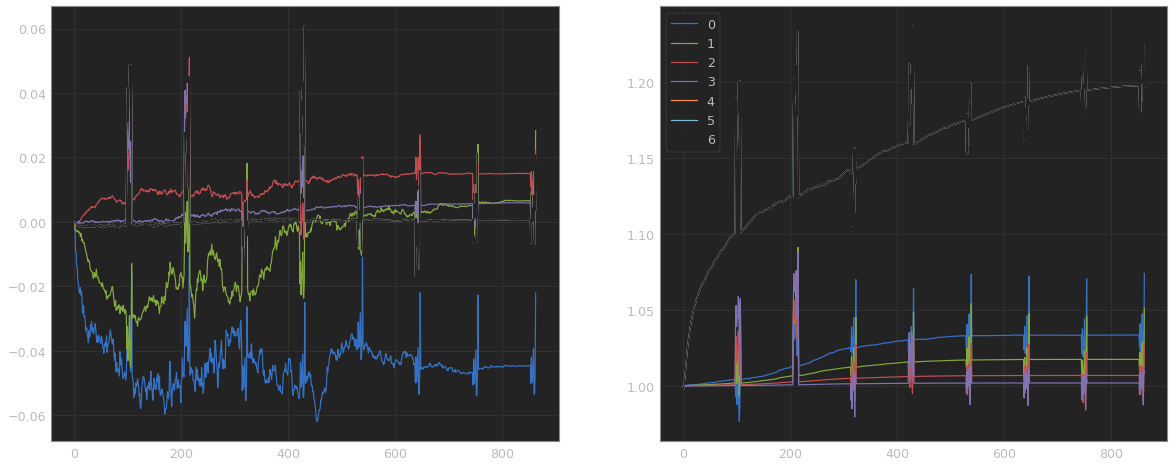

In [54]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(8, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(20,8))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(len(hooks[:-1])))

## More norms

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average (we don't need to since we process each layer independently)
2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size

In [ ]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [ ]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [nan, tensor(0.1321, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.56 s, sys: 862 ms, total: 5.42 s
Wall time: 5.42 s


*Thought experiment*: can this distinguish foggy days from sunny days (assuming you're using it before the first conv)?

### Instance norm

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7114)

In [ ]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [ ]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.46 s, sys: 718 ms, total: 5.18 s
Wall time: 5.18 s


*Question*: why can't this classify anything?

Lost in all those norms? The authors from the [group norm paper](https://arxiv.org/pdf/1803.08494.pdf) have you covered:

![Various norms]('images/norms.png')

### Group norm

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectorss of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: `(N, num_channels, *)`
- Output: `(N, num_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

### What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

In [ ]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [ ]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
%time run.fit(1, learn)

train: [2.35619296875, tensor(0.1649, device='cuda:0')]
valid: [2867.7198, tensor(0.2604, device='cuda:0')]
CPU times: user 1min 32s, sys: 835 ms, total: 1min 33s
Wall time: 1min 33s


With batch_size = 2 indeed the net learns very badly!

### Running Batch Norm

To solve this problem we introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std.

In [7]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom = mom
        self.register_buffer('eps',  torch.tensor([eps])) # note, I correctly registered eps as well because we need it at inference time
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x) # ok now we don't return the current batch stats from here
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c                       # but they're rather computed here! So here is differenciable! (*)
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)
    
# Note that the gradients would be rather difficult, as they depend on data on multiple batches!
# Deriving them by hand is probably unwieldy, so we're just hoping pytorch can cover for us I guess...

In [68]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [69]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [70]:
%time run.fit(1, learn)

train: [0.29424046875, tensor(0.9132, device='cuda:0')]
valid: [0.10689483642578125, tensor(0.9667, device='cuda:0')]
CPU times: user 3.52 s, sys: 585 ms, total: 4.11 s
Wall time: 4.09 s


This solves the small batch size issue!

### What can we do in a single epoch?

Now let's see with a decent batch size what result we can get.

In [71]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [72]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [73]:
%time run.fit(1, learn)

train: [0.15712552734375, tensor(0.9514, device='cuda:0')]
valid: [0.09815946044921875, tensor(0.9724, device='cuda:0')]
CPU times: user 14.9 s, sys: 503 ms, total: 15.4 s
Wall time: 15.4 s


Challenge to get a higher accuracy in one epoch!

In [88]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.5, 1.2), sched_cos(1.2, 0.4)]) 
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs  #with batch norm again, rather than running
                          +[partial(ParamScheduler,'lr', sched)])
%time run.fit(1, learn)

train: [0.167573203125, tensor(0.9485, device='cuda:0')]
valid: [0.05097836303710938, tensor(0.9850, device='cuda:0')]
CPU times: user 6.55 s, sys: 270 ms, total: 6.82 s
Wall time: 6.81 s


## Export

In [ ]:
nb_auto_export()